In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ekfplot import plot as ek
from ekfplot import colors as ec, colorlists

from pieridae.starbursts import sample

In [3]:
base_catalog, masks = sample.load_sample('/Users/kadofong/work/projects/merian/local_data/base_catalogs/mdr1_n708maglt26_and_pzgteq0p1.parquet')

/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/work/projects/merian/carpenter/src/carpenter/emission.py:338: RuntimeWarning: divide by zero encountered in reciprocal
  emission_correction = correct_NIISII(redshift_values, aperture_corrected_logmass)**-1


Computed aperture correction in 0.0 seconds.
Computed line contamination correction in 0.0 seconds.
Loading precomputed Galactic extinction map...
Interpolated Galactic extinction values from map.
Computed Galactic extinction correction in 0.5 seconds.
Computed internal extinction corrections in 0.6 seconds.


/Users/kadofong/work/projects/merian/agrias/python/agrias/photometry.py:115: RuntimeWarning: invalid value encountered in log10
  lsq_y = np.log10(np.array([ fdict[band] for band in plawbands ]))
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/kadofong/opt/miniconda3/envs/merian/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
datadir = '../../../local_data/pieridae_output/starlet/msorabove_v0/'
for sid in tqdm(base_catalog.index):
    filename = f'{datadir}/{sid}/{sid}_i_results.pkl'
    if not os.path.exists(filename):
        continue
    with open(filename, 'rb') as f:
        x = pickle.load(f)
    base_catalog.loc[sid, 'logmass_adjusted'] = x['logmass_adjusted']
base_catalog.loc[base_catalog['logmass_adjusted'].isna(),'logmass_adjusted'] = base_catalog.loc[base_catalog['logmass'].isna(),'logmass_adjusted']

100%|█████████████████████████████████| 196667/196667 [00:20<00:00, 9481.33it/s]


In [5]:
catalog = base_catalog.loc[masks['is_good'][0]&masks['is_msorabove'][0]]

In [6]:
cc_l = np.array(list(colorlists.hcbold.values()))[[0,3]]

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_95475/415830083.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axarr[idx].scatter(


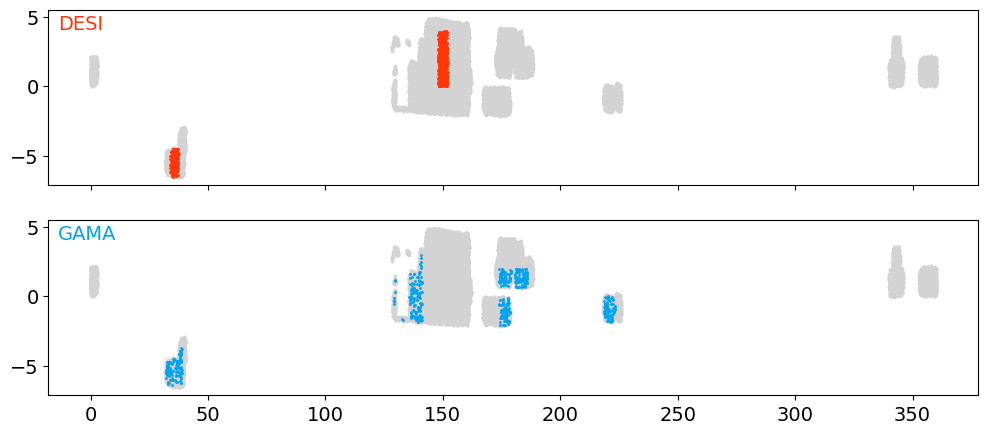

In [7]:
fig, axarr = plt.subplots(2,1,figsize=(12,5), sharex=True, sharey=True)

for ax in axarr:
    ax.scatter(
        catalog.loc[:,'RA'],
        catalog.loc[:,'DEC'],
        s=3,
        c='lightgrey'
    )

for idx, survey in enumerate(['desi','gama']):
    is_survey = catalog['z_source'] == survey
    cc = ec.ColorBase(cc_l[idx]).modulate(0.,0.3).base
    
    axarr[idx].scatter(
        catalog.loc[is_survey,'RA'],
        catalog.loc[is_survey,'DEC'],
        s=1,
        c=cc
    )
    ek.text(0.01, 0.975, survey.upper(), ax=axarr[idx], color=cc,)

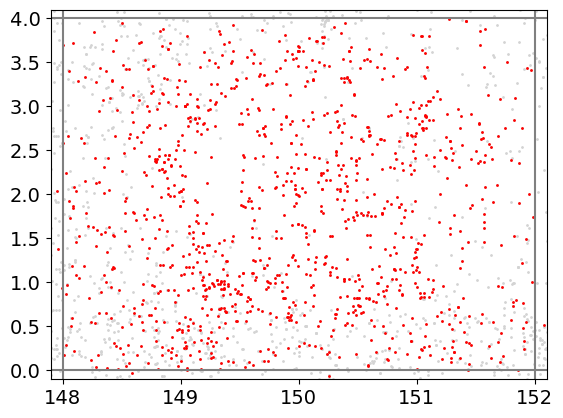

In [8]:
has_specz = ~np.isnan(catalog['z_spec'])

plt.scatter(
    catalog.loc[:,'RA'],
    catalog.loc[:,'DEC'],
    s=1,
    c='lightgrey'
)

plt.scatter(
    catalog.loc[has_specz,'RA'],
    catalog.loc[has_specz,'DEC'],
    s=1,
    c='r',
)
plt.xlim(147.9, 152.1)
plt.ylim(-0.1, 4.1)
plt.axvline(152., color='grey')
plt.axvline(148., color='grey')
plt.axhline(0., color='grey')
plt.axhline(4., color='grey')

In [9]:
from astropy import cosmology, units as u
from ekfstats import functions, sampling

cosmo = cosmology.FlatLambdaCDM(70.,0.3)

In [32]:
test_region = (catalog['RA']<152.)&(catalog['RA']>148.)&(catalog['DEC']>0.)&(catalog['DEC']<4.)
inband_specz = (catalog['z_spec']>0.03)&(catalog['z_spec']<0.15)
has_specz = ~np.isnan(catalog['z_spec'])

In [33]:
catalog['rmag'] = -2.5*np.log10(catalog['r_cModelFlux_Merian']*1e-9/3631.)

/var/folders/fs/f3k7bp2n3k1bldhn58thddt40000gn/T/ipykernel_95475/1248231934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  catalog['rmag'] = -2.5*np.log10(catalog['r_cModelFlux_Merian']*1e-9/3631.)


In [34]:
fq=np.loadtxt('/Users/kadofong/Downloads/fquench_gama.csv', delimiter=',')

In [35]:
dm = 0.1
mbins = np.arange(7.5,10.5, dm)
#mbins = np.arange(12, 25,.1)
volume = (cosmo.comoving_volume(0.1) - cosmo.comoving_volume(0.06)).to(u.Mpc**3)
sky_factor = ((16.*u.deg**2)/(4.*np.pi*u.sr)).decompose()
# \\ SAGAbg SMF
smf = functions.logschechter(10.**mbins, 1e-3, 10.**10.51, -1.41) + \
        functions.logschechter(10.**mbins,1.91e-3, 10.**10.51, -0.56) 
#smf = functions.logschechter(10.**mbins, 1e-3, 10.**11.21, -1.37) + \
#       functions.logschechter(10.**mbins, 2.3e-3, 10.**11.21, -0.41) 


purity = catalog.loc[inband_specz].shape[f0]/catalog.loc[has_specz].shape[0]
print(f'Purity = {purity*100:.2f} pct')

specz_counts,_=np.histogram(
    catalog.loc[inband_specz&test_region,'logmass_adjusted'],
    bins=mbins, 
    weights=np.full((test_region&inband_specz).sum(), 2./(dm * volume * sky_factor)), 
)

mc_specz = sampling.bootstrap_histcounts(
    catalog.loc[inband_specz&test_region,'logmass_adjusted'],
    bins=mbins, 
    weights=np.full((test_region&inband_specz).sum(), 2./(dm * volume * sky_factor)), 
)  

full_specz = sampling.bootstrap_histcounts(
    catalog.loc[test_region,'logmass_adjusted'],
    bins=mbins,
    weights=np.full(test_region.sum(), 1./(dm * volume * sky_factor))*2.*purity,
)

Purity = 80.62 pct


Text(0, 0.5, '$dn/d(\\log_{10}({\\rm M}_\\bigstar/{\\rm M}_\\odot))$')

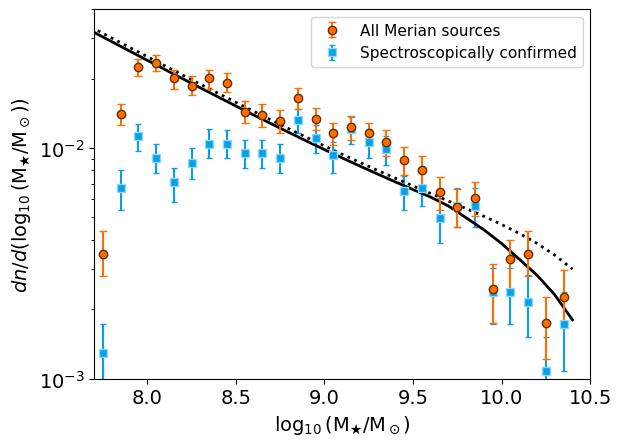

In [36]:
ax = plt.subplot(111)

ek.errorbar(
    sampling.midpts(mbins),
    np.median(mc_specz, axis=0),
    ylow=np.quantile(mc_specz,0.16, axis=0),
    yhigh=np.quantile(mc_specz,0.84, axis=0),
    color=colorlists.hcbold['blue'],
    markeredgecolor=ec.ColorBase(colorlists.hcbold['blue']).modulate(0.3).base,
    marker='s',
    capsize=2,
    label='Spectroscopically confirmed'
)


plt.plot(
    mbins,
    smf,
    color='k',
    ls=':',
    lw=2
)
plt.plot(
    mbins,
    smf*(1.-np.interp(mbins, fq[:,0], fq[:,1])),
    color='k',
    lw=2
)


ek.errorbar(
    sampling.midpts(mbins),
    np.median(full_specz, axis=0),
    ylow=np.quantile(full_specz,0.16, axis=0),
    yhigh=np.quantile(full_specz,0.84, axis=0),
    color=colorlists.hcbold['orange'],
    markeredgecolor=ec.ColorBase(colorlists.hcbold['orange']).modulate(-0.3).base,
    capsize=3,
    label='All Merian sources'
)
plt.legend(fontsize=11)

ek.reshuffle_legend(ax, [1,0], fontsize=11)

plt.ylim(1e-3, 4e-2)
plt.xlim(7.7, 10.5)
plt.yscale('log')
plt.xlabel(ek.common_labels['logmstar'])
plt.ylabel(ek.common_labels['smf'])

# Assign Merian galaxies to potential hosts

In [38]:
from astropy import coordinates

In [40]:
merian_coordinates = coordinates.SkyCoord(catalog['RA'].values, catalog['DEC'].values, unit='deg')

In [43]:
catalog

,RA,DEC,tract_Merian,patch_Merian,N708_gaap1p0Flux_Merian,N708_gaap1p0FluxErr_Merian,N708_cModelFlux_Merian,N708_cModelFluxErr_Merian,N540_gaap1p0Flux_Merian,N540_gaap1p0FluxErr_Merian,...,oiiiew,rmag,F_Ha_obs,L_Ha,L_OIII,n540_apercorr,i_apercorr,lineratio,pz,logmass_adjusted
M2950279968392759821,33.361103,-6.277179,8281,55,49190.655075,144.197265,146362.827007,346.801371,31715.482048,64.283596,...,3.041071,18.715154,1.237258e-15,2.976000e+40,8.699999e+39,2.984484,3.105213,0.292339,0.625655,9.294481
M2950284366439289368,33.210040,-6.305714,8281,56,5299.452850,117.818598,7081.272628,134.218521,3010.271309,82.564340,...,61.129399,22.111347,2.841824e-16,6.574871e+39,6.610896e+39,1.583314,1.654426,1.005479,0.275634,10.538187
M2950284366439293309,33.291219,-6.277189,8281,56,6361.976315,104.529618,7554.449672,113.027606,6139.200402,62.304052,...,109.082233,22.056164,2.085024e-16,4.216592e+39,1.169335e+40,1.168691,1.138347,2.773175,1.245090,8.168496
M2950284366439294691,33.290053,-6.268768,8281,56,30742.890403,155.578600,35088.055157,140.161553,22257.321648,91.367746,...,32.274289,20.396953,8.242490e-16,1.715933e+40,1.629144e+40,1.134626,1.079287,0.949422,0.910934,8.878030
M2950284366439297082,33.223697,-6.249205,8281,56,37200.356981,127.103353,117598.997927,347.824674,21787.224845,66.045586,...,8.761351,19.093151,3.515740e-15,7.505324e+40,1.561659e+40,3.326249,3.417955,0.208074,1.148802,9.095408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M3670750355655784953,159.994676,4.491515,10304,8,19204.244077,169.885121,26166.044618,207.634159,13078.067101,103.482366,...,17.846233,20.701072,4.446506e-16,1.033297e+40,7.688700e+39,1.366515,1.278093,0.744094,0.829378,8.471327
M3670750355655788205,159.986981,4.521514,10304,8,135515.445550,227.796824,408864.980627,527.227513,74806.067929,165.392766,...,NaN,17.636796,3.466787e-15,1.104331e+41,1.729470e+40,3.041908,3.303043,0.156608,0.883763,10.087491
M3670750355655790656,159.965727,4.532186,10304,8,11839.711245,157.961562,24902.935444,296.570340,8010.630819,87.797587,...,11.055084,20.650056,3.742567e-16,8.805529e+39,5.156177e+39,2.129129,2.121585,0.585561,0.288969,8.443156
M3670750355655791349,159.980262,4.540010,10304,8,35924.304409,193.636958,67408.492762,311.275121,26273.413641,122.855515,...,6.950458,19.573564,9.613006e-16,1.938501e+40,8.168803e+39,1.801390,1.991580,0.421398,0.760558,8.668996


In [385]:
from astropy.io import fits

In [283]:
cols = [
    'g_gaap1p0Flux_aperCorr_Merian',
    'N540_gaap1p0Flux_Merian',
    'r_gaap1p0Flux_aperCorr_Merian',
    'N708_gaap1p0Flux_Merian',
    'i_gaap1p0Flux_aperCorr_Merian',
    'z_gaap1p0Flux_aperCorr_Merian'    
]
wv_eff = np.array([
    4769.90,
    5400.,
    6370.44,
    7080.,
    7774.30,
    9199.28
])
    

In [383]:
sid = catalog.query('(z_spec>0.1)&(z_source=="gama")&(haew>10.)&(oiiiew>10.)').index[2]
row = catalog.loc[sid]
print(sid)

mcoord = coordinates.SkyCoord(row.RA, row.DEC, unit='deg')
gama.iloc[int(mcoord.match_to_catalog_sky(gcoords)[0])]['SPECID']

M3123598185302353677


'G02_Y4_041_258                   '

In [404]:
wv = xf[0].header['CD1_1']*(np.arange(xf[0].data.shape[1]) - xf[0].header['CRPIX1']) + xf[0].header['CRVAL1']

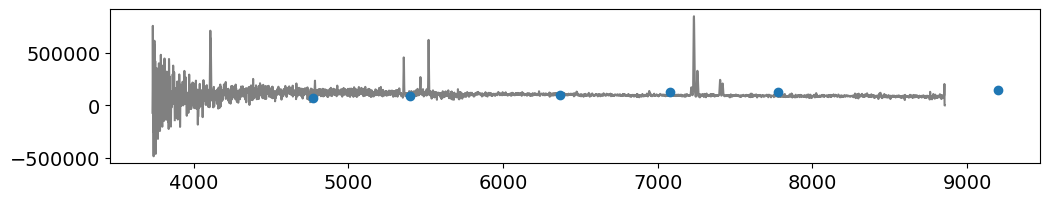

In [412]:
fig = plt.figure(figsize=(12,2))
plt.plot(
    wv,
    xf[0].data[0] * row[cols[2]] / np.interp(wv_eff[2], wv, xf[0].data[0]),
    color='grey'
)
plt.scatter(
    wv_eff,
    row[cols],
    zorder=5
)

In [414]:
row['z_spec']

0.10237